<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно постройть модель с предельно большим значением *F1*-меры. Довести метрику до 0.59. 

Дополнительно измерять *AUC-ROC*, сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import recall_score, precision_score, confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

RANDOM_STATE = 12345


data = pd.read_csv('/datasets/Churn.csv')



In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7799,7800,15619016,McMinn,660,Germany,Male,46,5.0,109019.65,2,1,1,33680.56,0
4300,4301,15633834,Milne,700,Germany,Female,28,3.0,99705.69,2,0,0,146723.72,0
6730,6731,15628697,Tung,631,Spain,Male,46,9.0,160736.63,1,0,1,93503.02,0
7877,7878,15793070,Fiorentino,494,Spain,Female,41,2.0,69974.66,2,1,0,188426.13,1
954,955,15660429,Ch'in,665,Spain,Female,42,2.0,156371.61,2,0,1,156774.94,1
3861,3862,15615126,Cocci,780,France,Female,37,3.0,0.00,2,0,0,182156.81,1
2774,2775,15650034,Kudryashova,564,France,Female,28,1.0,0.00,1,1,1,162428.05,0
1782,1783,15642002,Hayward,554,France,Female,35,6.0,117707.18,2,0,0,95277.15,1
9979,9980,15692664,Diribe,677,France,Female,58,1.0,90022.85,1,0,1,2988.28,0
4393,4394,15570051,Gill,775,Germany,Female,38,6.0,179886.41,2,0,0,153122.58,0


Фамилия нам не важна, этот столбец можно удалить совсем. Также нумерация строк и идентификатор клиента не нужны при решении поставленной задачи. Столбцы с географией и полом закодирую.

In [4]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Применяю метод прямого кодирования к таблице.

In [5]:
data_ohe = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

In [6]:
data_ohe.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7591,794,Spain,Female,30,1.0,154970.54,1,0,1,156768.45,0
6618,636,Germany,Female,29,NaN,97325.15,1,0,1,131924.38,0
4540,586,Germany,Male,32,1.0,149814.54,1,1,0,31830.06,0
8634,741,France,Male,39,NaN,0.00,1,0,1,40207.06,0
8919,673,France,Male,32,8.0,121240.76,1,1,0,116969.73,0


In [7]:
data_ohe = pd.get_dummies(data_ohe, drop_first=True)

In [8]:
data_ohe.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
4127,712,52,9.0,0.00,1,1,1,117977.45,1,0,1,1
2480,638,37,2.0,89728.86,2,1,1,37294.88,0,1,0,1
746,844,18,2.0,160980.03,1,0,0,145936.28,0,0,0,1
2801,498,29,8.0,127864.26,1,1,1,46677.90,0,0,1,1
1221,791,37,2.0,163789.49,2,1,0,75832.53,0,0,0,1


In [9]:
data_ohe['Tenure'].nunique()

11

In [10]:
data_ohe['Tenure'].isna().sum()

909

In [11]:
print('В предложенной выборке', round(data_ohe['Tenure'].isna().sum()*100/data_ohe['Tenure'].count(), 2), '% составляют утраченные данные. ')

В предложенной выборке 10.0 % составляют утраченные данные. 


Восстановить их не представляется возможным. Раз в выборке есть пустые ячейки, то и в последующей работе могут быть пустоты. Посмотрю матрицу корреляций.

<AxesSubplot:>

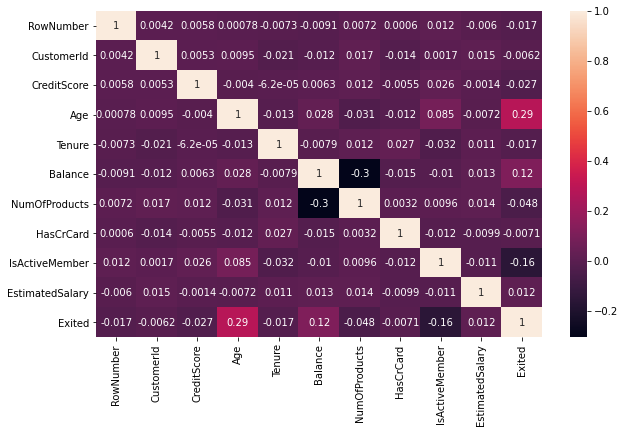

In [12]:
correlation_matrix = data.corr()

plt.figure(figsize= (10, 6))
sns.heatmap(correlation_matrix, annot = True)

Как будто данные из столбца 'Tenure' не связаны сильно с другими величинами. Вообще, по матрице можно сделать вывод, что на целевой признак влияют три параметра - 'Age', 'Balance' и 'IsActiveMember'.

Наличие Nan в столбце 'Tenure' будет мешать обработке данных. Нужно с ними что-то сделать.

Определю, влияет ли этот признак на целевой, с помощью features_importances.

In [13]:
from catboost import CatBoostClassifier

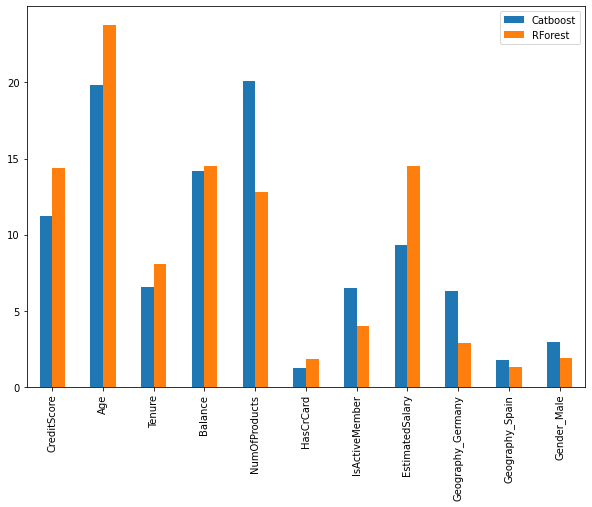

In [14]:
data_ohe_full=data_ohe.dropna(subset=['Tenure'])



model_test = RandomForestClassifier(random_state=RANDOM_STATE)
model_test.fit(X = data_ohe_full.drop(['Exited'], axis=1), y = data_ohe_full['Exited'])
model_cat = CatBoostClassifier(random_state=RANDOM_STATE, silent=True)
model_cat.fit(X = data_ohe_full.drop(['Exited'], axis=1), y = data_ohe_full['Exited'])

DF = pd.DataFrame({'Catboost' : model_cat.get_feature_importance(),
                        'RForest'  : list(map(lambda x: x*100, model_test.feature_importances_))},
                       index=data_ohe_full.drop(['Exited'], axis=1).columns)

fig, ax = plt.subplots(figsize=(10,7))
ax = DF.plot.bar(ax=ax)

Слабое влияние на целевую величину и отсутствие существенных корреляций сдругими величинами, наверное, позволяет заполнить средним все пропуски.
Пробовала также убрать 'HasCrCard','GenderMale' и 'Geography_Spain', но модель получалась недостаточного качества. Поэтому, хоть важность этих параметров кажется несущественной на фоне других, они вносят ощутимый вклад в формирование хорошего результата.

In [15]:

data_ohe['Tenure'].describe()


count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

In [16]:
data_ohe['Tenure']  = data_ohe['Tenure'].fillna(data_ohe['Tenure'].mean()) #2.76 std
data_ohe['Tenure'].unique()

array([ 2.        ,  1.        ,  8.        ,  7.        ,  4.        ,
        6.        ,  3.        , 10.        ,  5.        ,  9.        ,
        0.        ,  4.99769002])

In [17]:
data_ohe['Tenure'].describe()

count    10000.00000
mean         4.99769
std          2.76001
min          0.00000
25%          3.00000
50%          4.99769
75%          7.00000
max         10.00000
Name: Tenure, dtype: float64

Стандартное отклонение меняется, не могу подобрать величину, чтоб оставалось таким же, как до заполнения. Надеюсь, такое небольшое отклонение не критично. Данные получились чуть более скученные, чем до заполнения пропусков, что теоретически улучшило выборку.


Посмотрим, насколько несбалансированы классы.

In [18]:
data_ohe['Exited'].unique()

array([1, 0])

In [19]:
print('Нулевого класса в выборке -', round(data_ohe[data_ohe['Exited']==0]['Exited'].count()*100/data_ohe['Exited'].count(), 2),'%')

Нулевого класса в выборке - 79.63 %


In [20]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Бинарные данные переведу в int.

In [21]:
data_ohe['Geography_Germany'] = data_ohe['Geography_Germany'].astype('int')
data_ohe['Geography_Spain'] = data_ohe['Geography_Spain'].astype('int')
data_ohe['Gender_Male'] = data_ohe['Gender_Male'].astype('int')

In [22]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  int64  
 10  Geography_Spain    10000 non-null  int64  
 11  Gender_Male        10000 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 937.6 KB


Провожу разделение выборок с учётом целевого класса (использую аргумент stratify, ориентируя его на классы из target'а)

In [23]:
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=RANDOM_STATE, stratify=target_valid_test)

In [24]:
print('shapes:\nf_t =',features_train.shape, '\nf_v =', features_valid.shape, '\nf_tst =', features_test.shape,
      '\nt_t =', target_train.shape, '\nt_v =', target_valid.shape, '\nt_tst =', target_test.shape)

shapes:
f_t = (6000, 11) 
f_v = (2000, 11) 
f_tst = (2000, 11) 
t_t = (6000,) 
t_v = (2000,) 
t_tst = (2000,)


In [25]:
name_data = [target_train, target_valid, target_test]
text_data = ['target_train', 'target_valid', 'target_test']
for i in range(len(name_data)):
    name = name_data[i]
    print('Нулевого класса в выборке', text_data[i], '-', round(name[name==0].count()*100/name.count(), 2),'%')

Нулевого класса в выборке target_train - 79.63 %
Нулевого класса в выборке target_valid - 79.6 %
Нулевого класса в выборке target_test - 79.65 %


Баланс классов в тренировочной и валидационной выборках такой же, как в исходной.

Масштабирую признаки.

In [26]:
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler()

In [27]:
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

In [28]:
features_train = pd.DataFrame(features_train_scaled, columns=features_train.columns, index=features_train.index)
features_valid = pd.DataFrame(features_valid_scaled, columns=features_valid.columns, index=features_valid.index)
features_test = pd.DataFrame(features_test_scaled, columns=features_test.columns, index=features_test.index)

In [29]:
features_valid.sample(5)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
299,-0.236529,-0.571860,-0.002708,-1.219673,0.820981,0.655433,0.969466,0.057947,-0.575041,-0.575811,0.907278
3003,-0.720933,1.525251,0.360677,0.446765,-0.914708,-1.525709,0.969466,1.309639,-0.575041,-0.575811,0.907278
3378,-1.246563,3.145746,-0.002708,0.285567,-0.914708,0.655433,0.969466,-0.377325,1.739007,-0.575811,0.907278
4738,0.536457,0.095403,-0.003548,0.434678,-0.914708,-1.525709,-1.031496,-1.576364,-0.575041,-0.575811,-1.102198
1490,1.515573,-0.762506,1.087448,-1.219673,0.820981,0.655433,-1.031496,0.304398,-0.575041,1.736682,-1.102198


In [30]:
features_test.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3439,0.989942,-0.285890,-0.003548,1.055389,-0.914708,0.655433,0.969466,1.617093,-0.575041,-0.575811,0.907278
5779,0.350941,0.095403,-1.092865,-0.096671,-0.914708,0.655433,0.969466,0.261851,-0.575041,1.736682,0.907278
5487,1.165152,-0.381213,-0.003548,-1.219673,-0.914708,0.655433,0.969466,-1.199871,-0.575041,-0.575811,0.907278
7009,0.227263,-1.048476,0.360677,-1.219673,-0.914708,-1.525709,0.969466,-1.591970,-0.575041,-0.575811,-1.102198
6934,-1.030127,0.000079,-1.092865,0.635518,0.820981,0.655433,0.969466,1.655323,-0.575041,1.736682,0.907278


In [31]:
features_train.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1244,-0.648788,-0.095244,-1.819636,0.891177,0.820981,-1.525709,-1.031496,-1.193659,1.739007,-0.575811,-1.102198
7462,-0.411739,0.095403,1.450834,-1.219673,-0.914708,0.655433,0.969466,0.855150,-0.575041,-0.575811,0.907278
8152,0.041746,-0.285890,-1.092865,-1.219673,0.820981,0.655433,0.969466,0.803867,-0.575041,1.736682,-1.102198
2803,0.567377,0.381372,0.724063,0.058038,-0.914708,0.655433,0.969466,0.047006,1.739007,-0.575811,-1.102198
4515,0.783813,-0.857830,1.087448,0.923607,-0.914708,0.655433,0.969466,0.824209,-0.575041,1.736682,0.907278


## Исследование задачи

In [32]:
print('Логистическая регрессия')
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')  # class_weight='balanced' не беру, потому что сначала считаем без балансировки
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique())
print("f1:", f1_score(target_valid, predicted_valid))
print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('-----------------------------------------------------------')



Логистическая регрессия
Полнота: 0.20833333333333334 
Точность: 0.6115107913669064
Матрица ошибок:
 [[1538   54]
 [ 323   85]]
Оригинальные значения в предсказании: [1 0]
f1: 0.3107861060329068
roс_auc: 0.787452889447236
-----------------------------------------------------------


In [33]:
print('Решающее дерево')
model = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Полнота:', recall_score(target_valid, predicted_valid))
print('Точность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique())
print("f1:",f1_score(target_valid, predicted_valid))
print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('-----------------------------------------------------------') 


Решающее дерево
Полнота: 0.4803921568627451
Точность: 0.6405228758169934
Матрица ошибок:
 [[1482  110]
 [ 212  196]]
Оригинальные значения в предсказании: [0 1]
f1: 0.5490196078431373
roс_auc: 0.7724822026800671
-----------------------------------------------------------


In [34]:
print('Случайный лес') 
model=RandomForestClassifier(n_estimators=20, max_depth=5, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique()) 
print("f1:",f1_score(target_valid, predicted_valid))
print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))



Случайный лес
Полнота: 0.43137254901960786 
Точность: 0.7892376681614349
Матрица ошибок:
 [[1545   47]
 [ 232  176]]
Оригинальные значения в предсказании: [0 1]
f1: 0.5578446909667195
roс_auc: 0.8624533513154005


Разнообразим поиски.
В Дереве переберём значения глубины, а в Лесу - количество деревьев и глубину. Поищем лучшие варианты.

In [35]:
print('Решающее дерево')
f1=-1
best_depth = -1
for depth in range(1, 100):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > f1:
        f1 = f1_score(target_valid, predicted_valid)
        best_depth = depth
print('best_depth =', best_depth, '\nf1 =', f1)

model = DecisionTreeClassifier(max_depth=best_depth, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)

print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique())

print('-----------------------------------------------------------')



Решающее дерево
best_depth = 7 
f1 = 0.5924855491329479
roс_auc: 0.8230390617302197
Полнота: 0.5024509803921569 
Точность: 0.721830985915493
Матрица ошибок:
 [[1513   79]
 [ 203  205]]
Оригинальные значения в предсказании: [0 1]
-----------------------------------------------------------


In [36]:
print('Случайный лес')
f1=-1

best_depth = -1
best_est = -1
for est in range(1, 20):
    for depth in range(1, 10):
        model=RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RANDOM_STATE)
        model.fit(features_train, target_train)
        predicted_valid=model.predict(features_valid)
        if f1_score(target_valid, predicted_valid) > f1:
            f1 = f1_score(target_valid, predicted_valid)
            best_depth = depth
            best_est = est
print('best_depth =', best_depth, 'best_est =', best_est, '\nf1 =', f1)

print('-----------------------------------------------------------')  


model=RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)

print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique()) 



Случайный лес
best_depth = 4 best_est = 1 
f1 = 0.6036269430051813
-----------------------------------------------------------
roс_auc: 0.8142327753965908
Полнота: 0.571078431372549 
Точность: 0.6401098901098901
Матрица ошибок:
 [[1461  131]
 [ 175  233]]
Оригинальные значения в предсказании: [0 1]


Случайный лес с глубиной 4 и одним деревом лидирует по показателю f1.

## Борьба с дисбалансом

Активируем параметр class_weight='balanced'.

In [37]:
print('Логистическая регрессия')
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique())
print("f1:", f1_score(target_valid, predicted_valid))
print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('-----------------------------------------------------------')


Логистическая регрессия
Полнота: 0.7377450980392157 
Точность: 0.41120218579234974
Матрица ошибок:
 [[1161  431]
 [ 107  301]]
Оригинальные значения в предсказании: [1 0]
f1: 0.5280701754385966
roс_auc: 0.7936526997733766
-----------------------------------------------------------


Лучше несбалансированного варианта логистической регрессии.

Нужно сбалансировать классы. Первое - применим метод балансировки через увеличение малочисленного класса в выборке.

In [38]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


print(features_upsampled.shape)
print(target_upsampled.shape)

(9666, 11)
(9666,)


In [39]:
print('Нулевого класса в выборке target_upsampled -', round(target_upsampled[target_upsampled==0].count()*100/target_upsampled.count(), 2),'%')

Нулевого класса в выборке target_upsampled - 49.43 %


In [40]:

print('Логистическая регрессия')
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("f1:", f1_score(target_valid, predicted_valid))
print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique())


print('-----------------------------------------------------------')

Логистическая регрессия
f1: 0.5246753246753246
roс_auc: 0.7937558503300819
Полнота: 0.7426470588235294 
Точность: 0.40562248995983935
Матрица ошибок:
 [[1148  444]
 [ 105  303]]
Оригинальные значения в предсказании: [1 0]
-----------------------------------------------------------


In [41]:
print('Решающее дерево')
f1=-1
best_depth = -1
for depth in range(1, 100):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > f1:
        f1 = f1_score(target_valid, predicted_valid)
        best_depth = depth
print('best_depth =', best_depth, '\nf1 =', f1)

model = DecisionTreeClassifier(max_depth=best_depth, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)

print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique())

print('-----------------------------------------------------------') 

Решающее дерево
best_depth = 6 
f1 = 0.575925925925926
roс_auc: 0.841197408611686
Полнота: 0.4681372549019608 
Точность: 0.7579365079365079
Матрица ошибок:
 [[1531   61]
 [ 217  191]]
Оригинальные значения в предсказании: [0 1]
-----------------------------------------------------------


In [42]:
print('Случайный лес')
f1=-1

best_depth = -1
best_est = -1
for est in range(1, 20):
    for depth in range(1, 10):
        model=RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RANDOM_STATE)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid=model.predict(features_valid)
        if f1_score(target_valid, predicted_valid) > f1:
            f1 = f1_score(target_valid, predicted_valid)
            best_depth = depth
            best_est = est
print('best_depth =', best_depth, 'best_est =', best_est, '\nf1 =', f1)

print('-----------------------------------------------------------')  


model=RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=RANDOM_STATE)
model.fit(features_upsampled, target_upsampled)
predicted_valid=model.predict(features_valid)
print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique()) 


Случайный лес
best_depth = 8 best_est = 17 
f1 = 0.6417445482866043
-----------------------------------------------------------
roс_auc: 0.8670104505369988
Полнота: 0.7573529411764706 
Точность: 0.5567567567567567
Матрица ошибок:
 [[1346  246]
 [  99  309]]
Оригинальные значения в предсказании: [1 0]


Успех. 

Воспользуемся другим методом. Уберём неважные.

In [43]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.26)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2464, 11)
(2464,)


In [44]:
print('Нулевого класса в выборке target_downsampled -', round(target_downsampled[target_downsampled==0].count()*100/target_downsampled.count(), 2),'%')

Нулевого класса в выборке target_downsampled - 50.41 %


In [45]:

print('Логистическая регрессия')
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("f1:", f1_score(target_valid, predicted_valid))
print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique())


print('-----------------------------------------------------------')



Логистическая регрессия
f1: 0.5283347863993025
roс_auc: 0.7925626909055079
Полнота: 0.7426470588235294 
Точность: 0.4100135317997294
Матрица ошибок:
 [[1156  436]
 [ 105  303]]
Оригинальные значения в предсказании: [1 0]
-----------------------------------------------------------


In [46]:
print('Решающее дерево')
f1=-1
best_depth = -1
for depth in range(1, 100):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > f1:
        f1 = f1_score(target_valid, predicted_valid)
        best_depth = depth
print('best_depth =', best_depth, '\nf1 =', f1)

model = DecisionTreeClassifier(max_depth=5, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid=model.predict(features_valid)

print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique())
print('-----------------------------------------------------------') 

Решающее дерево
best_depth = 5 
f1 = 0.5900681596884129
roс_auc: 0.8440425165040889
Полнота: 0.7426470588235294 
Точность: 0.4894991922455573
Матрица ошибок:
 [[1276  316]
 [ 105  303]]
Оригинальные значения в предсказании: [1 0]
-----------------------------------------------------------


In [47]:
print('Случайный лес')
f1=-1

best_depth = -1
best_est = -1
for est in range(1, 20):
    for depth in range(1, 10):
        model=RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RANDOM_STATE)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid=model.predict(features_valid)
        if f1_score(target_valid, predicted_valid) > f1:
            f1 = f1_score(target_valid, predicted_valid)
            best_depth = depth
            best_est = est
print('best_depth =', best_depth, 'best_est =', best_est, '\nf1 =', f1)

print('-----------------------------------------------------------')  


model=RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=RANDOM_STATE)
model.fit(features_downsampled, target_downsampled)
predicted_valid=model.predict(features_valid)
print('roс_auc:', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))
print('Полнота:', recall_score(target_valid, predicted_valid) ,'\nТочность:', precision_score(target_valid, predicted_valid))

print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
print('Оригинальные значения в предсказании:', pd.Series(predicted_valid).unique()) 


Случайный лес
best_depth = 6 best_est = 8 
f1 = 0.6269230769230769
-----------------------------------------------------------
roс_auc: 0.8641830475908956
Полнота: 0.7990196078431373 
Точность: 0.5158227848101266
Матрица ошибок:
 [[1286  306]
 [  82  326]]
Оригинальные значения в предсказании: [1 0]


Предыдущий метод балансировки дал лучший результат.

Выбираем модель случайного леса с глубиной 8 и количеством деревьев 17, метод балансировки - upsample.



## Тестирование модели

In [48]:
test_model = RandomForestClassifier(n_estimators=17, max_depth=8, random_state=RANDOM_STATE)

test_model.fit(features_upsampled, target_upsampled)

predicted = test_model.predict(features_test)

print('Полнота:', recall_score(target_test, predicted) ,'\nТочность:', precision_score(target_test, predicted))
print('Матрица ошибок:\n', confusion_matrix(target_test, predicted))
print('Оригинальные значения в предсказании:', pd.Series(predicted).unique())
print("f1:", f1_score(target_test, predicted))
print('roс_auc:', roc_auc_score(target_test, test_model.predict_proba(features_test)[:, 1]))
print('-----------------------------------------------------------')

Полнота: 0.6953316953316954 
Точность: 0.522140221402214
Матрица ошибок:
 [[1334  259]
 [ 124  283]]
Оригинальные значения в предсказании: [1 0]
f1: 0.5964172813487882
roс_auc: 0.8494411206275612
-----------------------------------------------------------


Результат выше ожидаемого.

## Чек-лист

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*